<a href="https://colab.research.google.com/github/LukasDrews97/histopathology-cancer-detection/blob/main/histopathologic_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.5 kB/s 
     |████████████████████████████████| 8.8 MB 27.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.2.0+cu92 which 

In [ ]:
import torch

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split

 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [ ]:
! pip install -q kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c4f57c4150f30cfdcef63186ec5a262c5a5673c7534350119f7b28a9e8fac8f2
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belkasimmohamed","key":"84979781fa09cb23e7acafc7253fc9b6"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:09<00:00, 84.1MB/s]
100% 6.31G/6.31G [01:09<00:00, 97.6MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('histopathologic-cancer-detection.zip')
zip.extractall()
# !unzip train.zip

In [ ]:
import os
print(len(os.listdir('../content/train')))
print(len(os.listdir('../content/test')))

220025
57458


In [ ]:
data = pd.read_csv('../content/train_labels.csv')
print(data.shape)

(220025, 2)


In [ ]:
print(data.head(10))
path='../content/train'

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8  559e55a64c9ba828f700e948f6886f4cea919261      0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0


In [ ]:
data.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

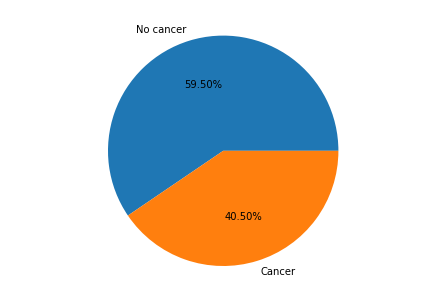

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No cancer', 'Cancer']
ax.pie(data.label.value_counts(),labels = labels, autopct ='%1.2f%%' )
plt.show()

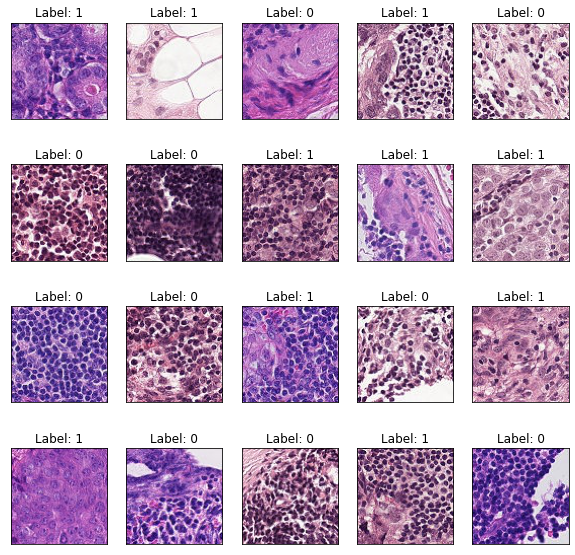

In [ ]:
fig = plt.figure(figsize=(10, 10))
path='../content/train/'
train_imgs =  os.listdir(path)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(path + img )
    plt.imshow(im)
    lab = data.loc[data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:
#There is a class imbalance in the training data with significantly more non-cancerous images (label '0')
# versus cancerous (label '1').
#Random Undersampling, this method seeks to randomly select and remove samples from the majority class, consequently reducing the number
# of examples in the majority class in the transformed data
print('Data befor')
data_lp = data[data['label'] == 1]
data_ln = data[data['label'] == 0]
print(len(data_lp), len(data_ln))
print('our data after')
data_ln = data_ln.sample(n = len(data_lp))
print(len(data_lp),len(data_ln))

data_bal = pd.concat([data_lp,data_ln]).sample(frac=1).reset_index(drop = True)
print('the shape of balance data')

data_bal.shape

89117 130908
89117 89117


(178234, 2)

In [ ]:
#Splitting the data into train and validation sets.
Lab = data['label']
train_data, validation_data = train_test_split(data_bal, stratify=data_bal.label , test_size=0.1)
print(len(train_data), len(validation_data))
print(train_data.label.value_counts())
print(validation_data.label.value_counts())
print(validation_data.head())


160410 17824
0    80205
1    80205
Name: label, dtype: int64
1    8912
0    8912
Name: label, dtype: int64
                                              id  label
68764   42b67afbfaac9650019062a1d25fd784d5d35432      1
143739  a0f81d0602e70ccce4f3b179e05c48710427de00      1
147463  2e0bc647a770640e952ba3e824b22a18aa5a37b5      0
97604   32110496bf70fc218c5f3361c79b6d165a240dbc      1
168190  24c803c9c3967766f97b69ebfcd3353217e87174      0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


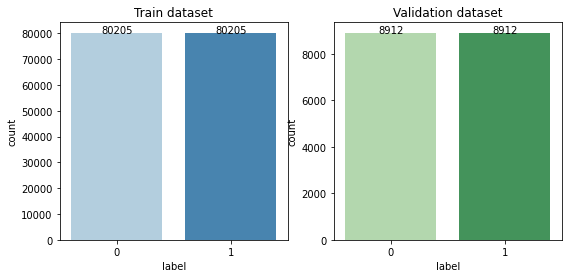

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(9,4))

sns.countplot(train_data.label, palette="Blues", ax=ax[0])
ax[0].set_title("Train dataset")
for i, rows in enumerate(train_data['label'].value_counts().values):
    ax[0].annotate(int(rows), xy=(i, rows), ha='center')
sns.countplot(validation_data.label, palette="Greens", ax=ax[1])
ax[1].set_title("Validation dataset")
for i, rows in enumerate(validation_data['label'].value_counts().values):
    ax[1].annotate(int(rows), xy=(i, rows), ha='center')

In [ ]:

#Lets update the dataset to include filename extensions

train_data['label']=train_data['label'].apply(lambda x:str(x))
train_data['id']=train_data['id'].apply(lambda x:str(x)+'.tif')

validation_data['label']=validation_data['label'].apply(lambda x:str(x))
validation_data['id']=validation_data['id'].apply(lambda x:str(x)+'.tif')

# Neuer Abschnitt

In [ ]:
#Images Auementation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path='../content/train'
train_data_ge = ImageDataGenerator(
    rescale = 1.0/255,

)
test_data_ge = ImageDataGenerator(
    rescale = 1.0/255,
)

training = train_data_ge.flow_from_dataframe(train_data , 
    directory =path,
    x_col="id",
    y_col="label",
    target_size = (96,96) ,
    batch_size = 64,
    seed = 1,
    class_mode = 'categorical',
    shuffle = True
    
    )
validation = train_data_ge.flow_from_dataframe(validation_data ,
    directory = path,
    x_col="id",
    y_col="label",
    target_size = (96,96),
    batch_size = 64,
    seed = 1,
    class_mode = 'categorical',
    shuffle = True
    
    )





Found 160410 validated image filenames belonging to 2 classes.
Found 17824 validated image filenames belonging to 2 classes.


In [ ]:
#build the model 
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,Flatten,AvgPool2D
from keras.models import Sequential
from keras import regularizers, optimizers
from tensorflow.keras import layers

model = Sequential()

#  First conv Layer
model.add(layers.Conv2D(16, (3, 3), strides = 1, padding = 'Same', activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Second conv2 Layer
model.add(layers.Conv2D(32, (3, 3), strides = 1, padding = 'Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

#  conv Layer
model.add(layers.Conv2D(64, (3, 3), strides = 1, padding = 'Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Conv4 Layer
model.add(layers.Conv2D(128, (3, 3), strides = 1, padding = 'Same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu" ))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

In [ ]:
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                      

In [ ]:
history = model.fit(training,epochs=9,validation_data=validation)

Epoch 1/9
2507/2507 [==============================] - 2074s 827ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/9
 175/2507 [=>............................] - ETA: 30:03 - loss: 0.6931 - accuracy: 0.5000

KeyboardInterrupt: ignored